In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import seaborn as sns
import folium
import folium.plugins as plugins
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### data preprocessing

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

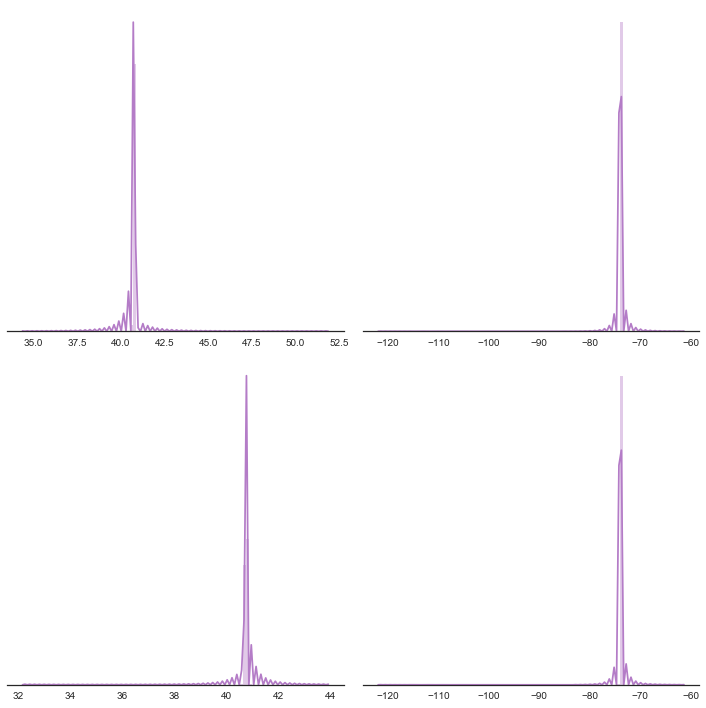

In [4]:
# seaborn sns
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

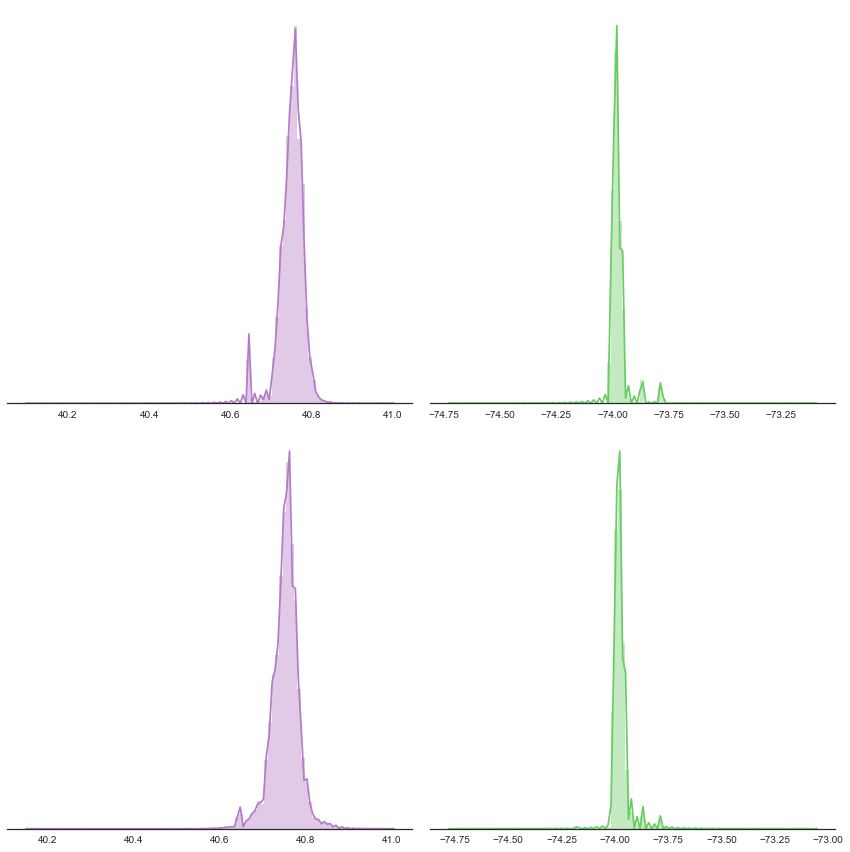

In [5]:
train = train.loc[(train.pickup_latitude > 40) & (train.pickup_latitude < 41)]
train = train.loc[(train.dropoff_latitude>40) & (train.dropoff_latitude < 41)]
train = train.loc[(train.dropoff_longitude > -75.5) & (train.dropoff_longitude < -73)]
train = train.loc[(train.pickup_longitude > -75.5) & (train.pickup_longitude < -73)]
train_data_new = train.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

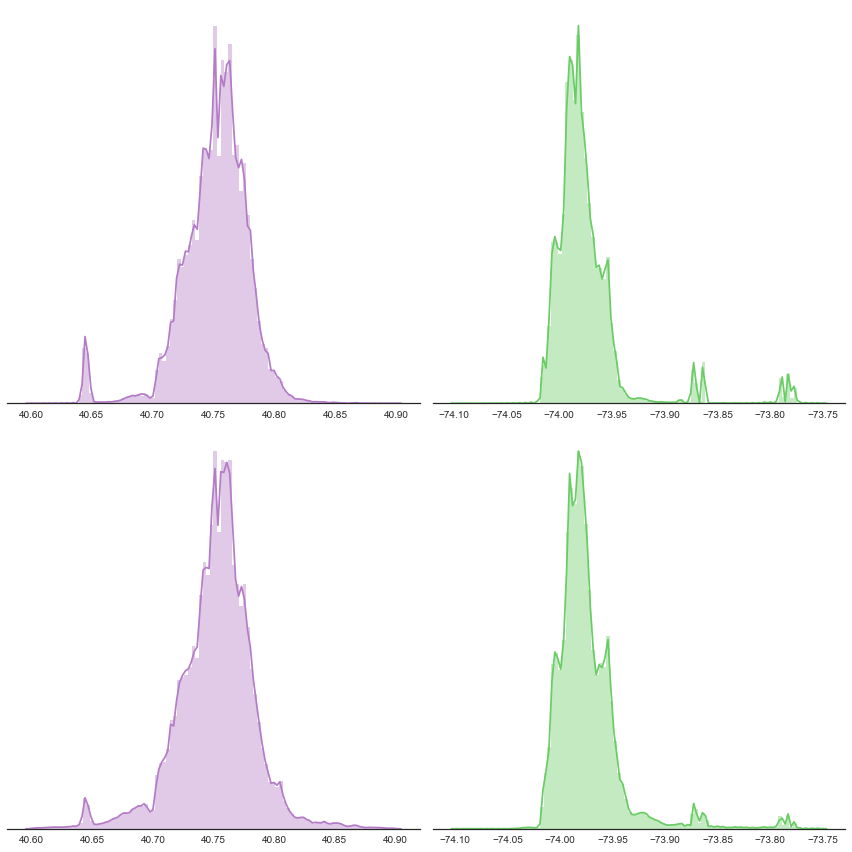

In [6]:
train = train.loc[(train.pickup_latitude > 40.6) & (train.pickup_latitude < 40.9)]
train = train.loc[(train.dropoff_latitude>40.6) & (train.dropoff_latitude < 40.9)]
train = train.loc[(train.dropoff_longitude > -74.10) & (train.dropoff_longitude < -73.75)]
train = train.loc[(train.pickup_longitude > -74.10) & (train.pickup_longitude < -73.75)]
train_data_new = train.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

In [7]:
train = train[train.passenger_count > 0]

In [8]:
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['dropoff_hour'] = pd.DatetimeIndex(train['dropoff_datetime']).hour
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['pickup_hour'] = pd.DatetimeIndex(train['pickup_datetime']).hour
total_rows = len(train.index)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


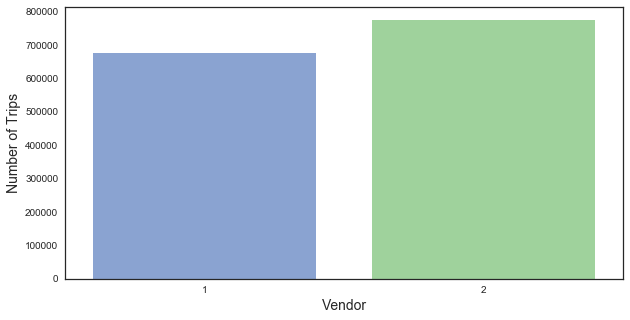

In [9]:
unique_vendors = set(train['vendor_id'].values)
vendor_popularity = train['vendor_id'].value_counts()

f = plt.figure(figsize=(10,5))
sns.barplot(vendor_popularity.index, vendor_popularity.values, alpha=0.7)
plt.xlabel('Vendor', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.show()

Maximum number of passengers on a trip :  8
Minimum number of passengers on a trip :  1
Average number of passengers on a trip :  1.6641392522339369


/Users/zhefeng/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


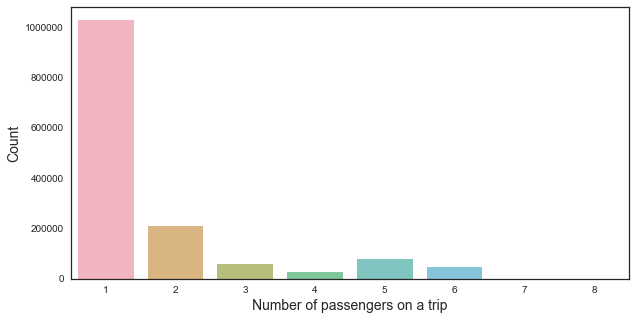

In [10]:
# Moving to passengers count column
pass_count = train['passenger_count']
print("Maximum number of passengers on a trip : ", np.max(pass_count.values))
print("Minimum number of passengers on a trip : ", np.min(pass_count.values))
print("Average number of passengers on a trip : ", np.mean(pass_count.values))

f = plt.figure(figsize=(10,5))
pass_count = train['passenger_count'].value_counts()
sns.barplot(pass_count.index, pass_count.values, alpha=0.7)
plt.xlabel('Number of passengers on a trip', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


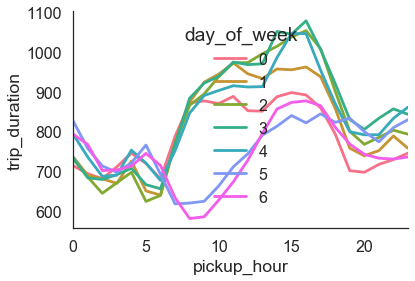

In [11]:
train.loc[:, 'week_of_year'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'day_of_year'] = train['pickup_datetime'].dt.dayofyear
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_hour_duration = pd.DataFrame(train.groupby(['day_of_week','pickup_hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="day_of_week", value="trip_duration")
sns.despine(bottom = False)

In [12]:
temp = train.copy()
train.loc[:, 'pick_date'] = train['pickup_datetime'].dt.date

ts_v1 = pd.DataFrame(train.loc[train['vendor_id']==1].groupby('pick_date')['trip_duration'].mean())
ts_v1.reset_index(inplace = True)
ts_v2 = pd.DataFrame(train.loc[train.vendor_id==2].groupby('pick_date')['trip_duration'].mean())
ts_v2.reset_index(inplace = True)

# use BokehJS
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
output_notebook()
p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Yearly Trip Duration Distribution for different days of the year'

for data, name, color in zip([ts_v1, ts_v2], ["vendor 1", "vendor 2"], Spectral4):
    df = data
    p.line(df['pick_date'], df['trip_duration'], line_width=2, color=color, alpha=0.8, legend=name)

p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)
train = temp

Loading BokehJS ...

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


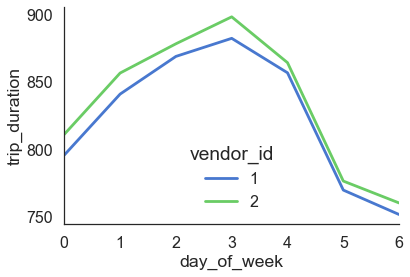

In [13]:
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


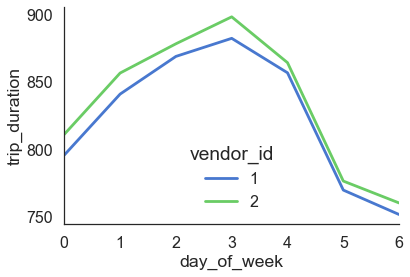

In [14]:
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

### Model training

In [15]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dropoff_hour,pickup_hour,week_of_year,day_of_year,day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,17,11,74,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,0,23,164,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,12,11,3,19,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,19,14,97,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,13,12,86,5


In [26]:
train['pickup_datetime'].values.astype('datetime64[D]').astype('float')

array([16893., 16897., 16928., ..., 16883., 16822., 16938.])

In [31]:
train['pickup_datetime']=train['pickup_datetime'].values.astype('datetime64[D]').astype('float')
train['dropoff_datetime']=train['dropoff_datetime'].values.astype('datetime64[D]').astype('float')

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zhefeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dropoff_hour,pickup_hour,week_of_year,day_of_year,day_of_week
199517,id1560204,1,16893.0,16893.0,4,-73.997437,40.721184,-73.993340,40.752491,N,2567,20,19,13,93,5
70880,id2619040,1,16897.0,16897.0,2,-74.008499,40.711700,-73.995102,40.739765,N,861,17,16,14,97,2
454820,id0543913,1,16928.0,16928.0,1,-73.984154,40.729309,-73.996071,40.737301,N,947,20,20,18,128,5
816653,id0939089,2,16814.0,16814.0,1,-73.963089,40.758537,-74.002670,40.760635,N,1125,21,21,2,14,3
293258,id2965270,1,16958.0,16958.0,1,-74.000931,40.736530,-74.001106,40.746441,N,358,13,13,23,158,0


In [33]:
train,test = train_test_split(train,test_size=0.3)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dropoff_hour,pickup_hour,week_of_year,day_of_year,day_of_week
64564,id1617366,2,16900.0,16900.0,1,-73.945351,40.786736,-73.977913,40.782913,N,641,20,20,14,100,5
1132676,id2602468,1,16921.0,16921.0,1,-74.006798,40.735687,-74.000008,40.682953,N,1363,3,2,17,121,5
716596,id2862820,2,16895.0,16895.0,2,-73.977226,40.758781,-73.984062,40.755581,N,319,15,14,14,95,0
530308,id0409393,2,16901.0,16901.0,1,-73.967964,40.768211,-73.945450,40.799095,N,1218,17,16,14,101,6
1248757,id3640720,2,16812.0,16812.0,1,-73.955132,40.765057,-73.963097,40.768322,N,355,15,15,2,12,1


In [89]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'dropoff_hour', 'pickup_hour', 'week_of_year',
       'day_of_year', 'day_of_week'],
      dtype='object')

In [90]:
test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'dropoff_hour', 'pickup_hour', 'week_of_year',
       'day_of_year', 'day_of_week'],
      dtype='object')

In [93]:
feature_names = list(train.columns)
do_not_use_for_training = ['id','store_and_fwd_flag', 'trip_duration','pickup_datetime', 'dropoff_datetime','dropoff_hour',]
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

In [94]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1990)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test_X[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

#### XGBoost

In [95]:
# parameters
xgb_pars1 = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,'subsample': 0.9, 'lambda': 1., 'nthread': -1, 
            'booster' : 'gbtree', 'silent': 1,'eval_metric': 'rmse', 
            'objective': 'reg:linear'}
xgb_model1 = xgb.train(xgb_pars1, dtrain, 10, watchlist, early_stopping_rounds=2,
                       maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % xgb_model1.best_score)

[0]	train-rmse:3.05368	valid-rmse:3.0528
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:1.62358	valid-rmse:1.62333
[2]	train-rmse:0.970166	valid-rmse:0.970842
[3]	train-rmse:0.710433	valid-rmse:0.712461
[4]	train-rmse:0.625372	valid-rmse:0.628572
[5]	train-rmse:0.559561	valid-rmse:0.563107
[6]	train-rmse:0.548167	valid-rmse:0.551853
[7]	train-rmse:0.539756	valid-rmse:0.543454
[8]	train-rmse:0.534427	valid-rmse:0.538465
[9]	train-rmse:0.527244	valid-rmse:0.53151
Modeling RMSLE 0.53151


In [102]:
feature_names

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pickup_hour',
 'week_of_year',
 'day_of_year',
 'day_of_week']

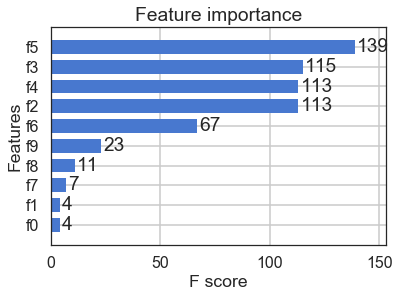

In [96]:
xgb.plot_importance(xgb_model1, max_num_features=28, height=0.7)

In [97]:
xgb_pars2 = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,'subsample': 0.9, 'lambda': 1., 'nthread': -1, 
            'booster' : 'gbtree', 'silent': 1,'eval_metric': 'rmse', 
            'objective': 'reg:linear'}
xgb_model2 = xgb.train(xgb_pars2, dtrain, 500, watchlist, early_stopping_rounds=50,
             maximize=False, verbose_eval=20)
print('Modeling RMSLE %.5f' % xgb_model2.best_score)

[0]	train-rmse:3.05368	valid-rmse:3.0528
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:0.458904	valid-rmse:0.464275
[40]	train-rmse:0.418164	valid-rmse:0.426199
[60]	train-rmse:0.401345	valid-rmse:0.411273
[80]	train-rmse:0.393432	valid-rmse:0.405971
[100]	train-rmse:0.386088	valid-rmse:0.401109
[120]	train-rmse:0.380435	valid-rmse:0.397101
[140]	train-rmse:0.375807	valid-rmse:0.394273
[160]	train-rmse:0.372669	valid-rmse:0.393114
[180]	train-rmse:0.36973	valid-rmse:0.392196
[200]	train-rmse:0.367417	valid-rmse:0.391539
[220]	train-rmse:0.364702	valid-rmse:0.390462
[240]	train-rmse:0.362084	valid-rmse:0.389722
[260]	train-rmse:0.359744	valid-rmse:0.389214
[280]	train-rmse:0.356795	valid-rmse:0.388297
[300]	train-rmse:0.354897	valid-rmse:0.387756
[320]	train-rmse:0.35301	valid-rmse:0.387277
[340]	train-rmse:0.351012	valid-rmse:0.387031
[360]	train-rmse:0.348794	valid-rmse:0

In [98]:
xgb_pars3 = {'min_child_weight': 100, 'eta': 0.1, 'colsample_bytree': 0.7, 'max_depth': 15,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
xgb_model3 = xgb.train(xgb_pars3, dtrain, 100000, watchlist, early_stopping_rounds=90,
             maximize=False, verbose_eval=100)
print('Modeling RMSLE %.5f' % xgb_model3.best_score)

[0]	train-rmse:5.41121	valid-rmse:5.41082
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 90 rounds.
[100]	train-rmse:0.361013	valid-rmse:0.388596
[200]	train-rmse:0.341833	valid-rmse:0.376408
[300]	train-rmse:0.32856	valid-rmse:0.36906
[400]	train-rmse:0.319707	valid-rmse:0.365123
[500]	train-rmse:0.312861	valid-rmse:0.362501
[600]	train-rmse:0.307142	valid-rmse:0.36082
[700]	train-rmse:0.30226	valid-rmse:0.359644
[800]	train-rmse:0.297545	valid-rmse:0.35853
[900]	train-rmse:0.29302	valid-rmse:0.357852
[1000]	train-rmse:0.288407	valid-rmse:0.357381
[1100]	train-rmse:0.284602	valid-rmse:0.357157
[1200]	train-rmse:0.280462	valid-rmse:0.356955
[1300]	train-rmse:0.276683	valid-rmse:0.356887
Stopping. Best iteration:
[1258]	train-rmse:0.277857	valid-rmse:0.356795

Modeling RMSLE 0.35679


In [103]:
xgb_pars4 = {'min_child_weight': 100, 'eta': 0.1, 'colsample_bytree': 0.7, 'max_depth': 15,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
xgb_model4 = xgb.train(xgb_pars4, dtrain, 100000, watchlist, early_stopping_rounds=200,
             maximize=False, verbose_eval=100)
print('Modeling RMSLE %.5f' % xgb_model4.best_score)

[0]	train-rmse:5.41121	valid-rmse:5.41082
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.361013	valid-rmse:0.388596
[200]	train-rmse:0.341833	valid-rmse:0.376408
[300]	train-rmse:0.32856	valid-rmse:0.36906
[400]	train-rmse:0.319707	valid-rmse:0.365123
[500]	train-rmse:0.312861	valid-rmse:0.362501
[600]	train-rmse:0.307142	valid-rmse:0.36082
[700]	train-rmse:0.30226	valid-rmse:0.359644
[800]	train-rmse:0.297545	valid-rmse:0.35853
[900]	train-rmse:0.29302	valid-rmse:0.357852
[1000]	train-rmse:0.288407	valid-rmse:0.357381
[1100]	train-rmse:0.284602	valid-rmse:0.357157
[1200]	train-rmse:0.280462	valid-rmse:0.356955
[1300]	train-rmse:0.276683	valid-rmse:0.356887
[1400]	train-rmse:0.273032	valid-rmse:0.356862
[1500]	train-rmse:0.269361	valid-rmse:0.356821
[1600]	train-rmse:0.265752	valid-rmse:0.356812
[1700]	train-rmse:0.262066	valid-rmse:0.356952
Stopping. Best iteration:
[1

In [104]:
from math import sqrt
def rmse(true, pred):
    return sqrt(mean_squared_error(true, pred))

In [117]:
pred = xgb_model4.predict(xgb.DMatrix(Xtr))

In [118]:
rmse(ytr, pred)

0.26018787932488835

In [119]:
pred = xgb_model4.predict(xgb.DMatrix(Xv))
rmse(yv, pred)

0.3570366105417989